In [128]:
import pandas as pd
import requests
import selenium
from selenium import webdriver  # Selenium es una herramienta para automatizar la interacción con navegadores web.
from webdriver_manager.chrome import ChromeDriverManager  # ChromeDriverManager gestiona la instalación del controlador de Chrome.
from selenium.webdriver.common.keys import Keys  # Keys es útil para simular eventos de teclado en Selenium.
from selenium.webdriver.support.ui import Select  # Select se utiliza para interactuar con elementos <select> en páginas web.
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.common.exceptions import NoSuchElementException # Excepciones comunes de selenium que nos podemos encontrar 
from bs4 import BeautifulSoup
from time import sleep 
import re
import sys 
import os
sys.path.append(os.path.abspath("../src"))   
from datetime import datetime
import psycopg2
from psycopg2 import OperationalError, errorcodes, errors

import matplotlib.pyplot as plt
import matplotlib_inline
import seaborn as sns


import funciones as f

Sacar lista supers

In [72]:
url_super = "https://super.facua.org/"
res_facua = requests.get(url_super)
sopa_mercados = BeautifulSoup(res_facua.content, "html.parser")
lista_mercados = sopa_mercados.findAll("a", {"class" :"nav-link"})
lista_supers= [mercado.getText().lower() for mercado in lista_mercados]
lista_supers.pop()
lista_supers


['mercadona', 'alcampo', 'carrefour', 'hipercor', 'dia', 'eroski']

Sacar lista productos

In [78]:
url_mercados = f"https://super.facua.org/mercadona/"
res_producto = requests.get(url_mercados)
sopa_productos = BeautifulSoup(res_producto.content, "html.parser")
lista_prod = sopa_productos.findAll("p", {"class" :"fw-bolder"})
lista_productos= [mercado.getText().lower().replace(" ", "-") for mercado in lista_prod]
for i, producto in enumerate(lista_productos,start=1):
    id_prod= i
    nombre_producto= producto
    print(nombre_producto)
    print(id_prod)


aceite-de-girasol
1
aceite-de-oliva
2
leche
3


Sacar lista variantes


In [79]:
url_variante = "https://super.facua.org/mercadona/aceite-de-girasol/"
res_variante= requests.get(url_variante)
sopa_variante = BeautifulSoup(res_variante.content, "html.parser")
lista_var = sopa_variante.findAll("p", {"class" :"fw-bolder"})
lista_variantes= [variante.getText().lower().replace(" ", "-").replace(",", "").replace("º","").replace(".","") for variante in lista_var]
for i, variante in enumerate(lista_variantes, start=1):
    id_var= i
    nombre_variante= variante
    print(id_var)
    print(nombre_variante)

1
aceite-de-girasol-refinado-02-hacendado-1-l
2
aceite-de-girasol-refinado-02-hacendado-5-l


Lo comento para que no me moleste

In [73]:
# for mercado in lista_supers:
#     df_tablas= pd.DataFrame()
#     driver = webdriver.Chrome()
#     url_mercados = f"https://super.facua.org/{mercado}/"
#     driver.get(url_mercados)
#     sleep(3)
#     #aceptar cookie
#     driver.find_element("css selector", "#rcc-confirm-button").click()
#     #hacer aquí la lista de productos
#     res_producto = requests.get(url_mercados)
#     sopa_productos = BeautifulSoup(res_producto.content, "html.parser")
#     lista_prod = sopa_productos.findAll("p", {"class" :"fw-bolder"})
#     lista_productos= [prod.getText().lower().replace(" ", "-") for prod in lista_prod]

#     for i, producto in enumerate(lista_productos):
#         driver.execute_script("window.scrollBy(0, 200);")
#         sleep(2)
#         #selecciona producto
#         driver.find_element("css selector", f"body > section:nth-child(4) > div > div.row.gx-4.gx-lg-5.row-cols-2.row-cols-md-3.row-cols-xl-4.justify-content-center > div:nth-child({i+1}) > div > div.card-footer.p-4.pt-0.border-top-0.bg-transparent > div > a").click()
#         sopa_variante = BeautifulSoup(driver.page_source, "html.parser")
#         lista_var = sopa_variante.findAll("p", {"class" :"fw-bolder"})
#         lista_variantes= [variante.getText().lower().replace(" ", "-").replace(",", "").replace("º","").replace(".","") for variante in lista_var]
#         lista_variantes_bien=[]
#         for elemento in lista_variantes:
#             if "aceite" in elemento or "leche" in elemento:
#                 lista_variantes_bien.append(elemento)
#         for j ,variante in enumerate(lista_variantes_bien):
#             while True:
#                 #selecciona variante
#                 try:
#                     sleep(2)
#                     driver.find_element("css selector", f"body > section:nth-child(4) > div > div:nth-child(7) > div:nth-child({j+1}) > div > div.card-footer.p-4.pt-0.border-top-0.bg-transparent > div > a").click()
#                     break
#                 except:
#                     driver.execute_script("window.scrollBy(0, 200);")
#             sopa_mercados = BeautifulSoup(driver.page_source, "html.parser")
#             tabla_general= sopa_mercados.findAll("table")
#             tablaindiv=tabla_general[-1]
#             #por aquí crear las columnas necesarias usando lista de productos y variante (mercado se pone formateado tal cual)
#             df_tablas=pd.concat([df_tablas, f.sacar_tabla(tablaindiv,mercado,producto,variante)])
#             driver.back()
#         driver.back()    
#     driver.close()
#     df_tablas.to_csv(f'../datos/datos{mercado}.csv', index=False)


In [3]:
# df_tablas.head()

In [69]:
lista=[]
lista_variantes_bien=["aceite de oliva", "oliva de aceite", "oliva aceite de", "leche merengada azul", "merengada leche azul", "merengada zaul leche", "caca"]     
for elemento in lista_variantes_bien:
    if "aceite" in elemento or "leche" in elemento:
        lista.append(elemento)
lista

['aceite de oliva',
 'oliva de aceite',
 'oliva aceite de',
 'leche merengada azul',
 'merengada leche azul',
 'merengada zaul leche']

Carga de datos

In [74]:
alcampo=pd.read_csv("../datos/datosalcampo.csv")
mercadona=pd.read_csv("../datos/datosmercadona.csv")
carrefour=pd.read_csv("../datos/datoscarrefour.csv")
dia=pd.read_csv("../datos/datosdia.csv")
eroski=pd.read_csv("../datos/datoseroski.csv")
hipercor=pd.read_csv("../datos/datoshipercor.csv")

In [75]:
alcampo.head()

,Día,Precio (€),Variación,supermercado,producto,variante
0,30/06/2024,"5,88",=,alcampo,aceite-de-girasol,campomar-nature-aceite-de-girasol-ecológico-ca...
1,01/07/2024,"5,88",=,alcampo,aceite-de-girasol,campomar-nature-aceite-de-girasol-ecológico-ca...
2,12/07/2024,"5,88",=,alcampo,aceite-de-girasol,campomar-nature-aceite-de-girasol-ecológico-ca...
3,13/07/2024,"5,88",=,alcampo,aceite-de-girasol,campomar-nature-aceite-de-girasol-ecológico-ca...
4,14/07/2024,"5,88",=,alcampo,aceite-de-girasol,campomar-nature-aceite-de-girasol-ecológico-ca...


In [76]:
mercadona.head()

,Día,Precio (€),Variación,supermercado,producto,variante
0,12/07/2024,"1,45",=,mercadona,aceite-de-girasol,aceite-de-girasol-refinado-02-hacendado-1-l
1,13/07/2024,"1,45",=,mercadona,aceite-de-girasol,aceite-de-girasol-refinado-02-hacendado-1-l
2,14/07/2024,"1,45",=,mercadona,aceite-de-girasol,aceite-de-girasol-refinado-02-hacendado-1-l
3,15/07/2024,"1,45",=,mercadona,aceite-de-girasol,aceite-de-girasol-refinado-02-hacendado-1-l
4,16/07/2024,"1,45",=,mercadona,aceite-de-girasol,aceite-de-girasol-refinado-02-hacendado-1-l


In [77]:
eroski.head()

,Día,Precio (€),Variación,supermercado,producto,variante
0,12/07/2024,"1,89",=,eroski,aceite-de-girasol,aceite-alto-oleico-eroski-botella-1-litro
1,13/07/2024,"1,89",=,eroski,aceite-de-girasol,aceite-alto-oleico-eroski-botella-1-litro
2,14/07/2024,"1,89",=,eroski,aceite-de-girasol,aceite-alto-oleico-eroski-botella-1-litro
3,15/07/2024,"1,89",=,eroski,aceite-de-girasol,aceite-alto-oleico-eroski-botella-1-litro
4,16/07/2024,"1,89",=,eroski,aceite-de-girasol,aceite-alto-oleico-eroski-botella-1-litro


In [78]:
dia.head()

,Día,Precio (€),Variación,supermercado,producto,variante
0,29/08/2024,"1,99",=,dia,aceite-de-girasol,aceite-de-girasol-alto-oleico-especial-freidor...
1,30/08/2024,"1,99",=,dia,aceite-de-girasol,aceite-de-girasol-alto-oleico-especial-freidor...
2,31/08/2024,"1,99",=,dia,aceite-de-girasol,aceite-de-girasol-alto-oleico-especial-freidor...
3,01/09/2024,"1,99",=,dia,aceite-de-girasol,aceite-de-girasol-alto-oleico-especial-freidor...
4,02/09/2024,"1,99",=,dia,aceite-de-girasol,aceite-de-girasol-alto-oleico-especial-freidor...


In [79]:
hipercor.head()

,Día,Precio (€),Variación,supermercado,producto,variante
0,13/07/2024,"1,40",=,hipercor,aceite-de-girasol,abrilsol-aceite-refinado-de-girasol-botella-1-l
1,14/07/2024,"1,40",=,hipercor,aceite-de-girasol,abrilsol-aceite-refinado-de-girasol-botella-1-l
2,15/07/2024,"1,40",=,hipercor,aceite-de-girasol,abrilsol-aceite-refinado-de-girasol-botella-1-l
3,16/07/2024,"1,40",=,hipercor,aceite-de-girasol,abrilsol-aceite-refinado-de-girasol-botella-1-l
4,17/07/2024,"1,40",=,hipercor,aceite-de-girasol,abrilsol-aceite-refinado-de-girasol-botella-1-l


In [80]:
carrefour.head()

,Día,Precio (€),Variación,supermercado,producto,variante
0,12/07/2024,"21,40",=,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l
1,13/07/2024,"21,40",=,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l
2,14/07/2024,"21,40",=,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l
3,15/07/2024,"21,40",=,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l
4,16/07/2024,"21,40",=,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l


Creación Data Frame Total y Exploración inicial

In [81]:
df= pd.DataFrame()
df_total= pd.concat([df,carrefour,mercadona,eroski,dia,hipercor,alcampo])

In [82]:
df_total.head()

,Día,Precio (€),Variación,supermercado,producto,variante
0,12/07/2024,"21,40",=,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l
1,13/07/2024,"21,40",=,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l
2,14/07/2024,"21,40",=,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l
3,15/07/2024,"21,40",=,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l
4,16/07/2024,"21,40",=,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l


**RESULTADOS INICIALES DE EXPLORACION**    


Contamos con un Data Frame de 134114 filas y 6 columnas.

*Nulos:*  

- No cuenta con ningun dato nulo que tengamos que tratar


*Duplicados:*  

- Contamos con 1160 filas duplicadas lo que supone un 0,86% del total de filas.  
- Tras analizarlos y comprobar la web, nos dimos cuenta de que los podemos eliminar ya que en la propia web aparecen productos duplicados(Nos quedamos con un Data Frame con 132954 filas y 6 columnas). 

*Formatos:*  

- En la columna variacion quise convertir los iguales a 0, quedarme solo con los porcentajes y luego ya pasar a float.  
- En la columna precio cambié las , por los . y los pasé a float.   
- En la columna Día la fecha debería estar en formato fecha así que la cambié. 





Tratamos los duplicados

In [83]:
df_total.shape

(134114, 6)

In [86]:
df_total.duplicated().sum()

np.int64(1160)

In [84]:
round((df_total.duplicated().sum()/len(df_total))*100, 2)

np.float64(0.86)

In [87]:
df_total[df_total.duplicated()].head()

,Día,Precio (€),Variación,supermercado,producto,variante
11872,15/07/2024,"1,08",=,carrefour,leche,leche-desnatada-central-lechera-asturiana-brik...
11873,16/07/2024,"1,08",=,carrefour,leche,leche-desnatada-central-lechera-asturiana-brik...
11874,17/07/2024,"1,08",=,carrefour,leche,leche-desnatada-central-lechera-asturiana-brik...
11875,18/07/2024,"1,08",=,carrefour,leche,leche-desnatada-central-lechera-asturiana-brik...
11876,19/07/2024,"1,08",=,carrefour,leche,leche-desnatada-central-lechera-asturiana-brik...


In [88]:
df_total.drop_duplicates(inplace=True)

Formateamos

In [89]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132954 entries, 0 to 32867
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype 
---  ------        --------------   ----- 
 0   Día           132954 non-null  object
 1   Precio (€)    132954 non-null  object
 2   Variación     132954 non-null  object
 3   supermercado  132954 non-null  object
 4   producto      132954 non-null  object
 5   variante      132954 non-null  object
dtypes: object(6)
memory usage: 7.1+ MB


In [90]:
df_total["Precio (€)"]=df_total["Precio (€)"].str.replace(",", ".").astype(float)



In [91]:
df_total.sample(5)

,Día,Precio (€),Variación,supermercado,producto,variante
38721,19/07/2024,1.89,=,hipercor,leche,puleva-leche-fresca-semidesnatada-ecológica-bo...
19636,25/10/2024,6.42,"+0,12 (1,90%)",alcampo,leche,central-lechera-asturiana-leche-de-vaca-semide...
80,02/08/2024,9.75,=,dia,aceite-de-girasol,aceite-de-girasol-coosol-garrafa-5-l
9377,15/09/2024,6.46,=,alcampo,aceite-de-oliva,maestros-de-hojiblanca-oda-n--5--aceite-de-oli...
35735,31/07/2024,1.45,=,hipercor,leche,pascual-leche-desnatada-sin-lactosa-brik-1-l


In [92]:
df_total["Variación"]=df_total["Variación"].str.replace("+","").str.replace(",", ".").str.split(" ").str[0].str.replace("=", "0").astype(float)

In [93]:
df_total["Día"]=pd.to_datetime(df_total["Día"], dayfirst= True)

In [94]:
df_total.info()

<class 'pandas.core.frame.DataFrame'>
Index: 132954 entries, 0 to 32867
Data columns (total 6 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Día           132954 non-null  datetime64[ns]
 1   Precio (€)    132954 non-null  float64       
 2   Variación     132954 non-null  float64       
 3   supermercado  132954 non-null  object        
 4   producto      132954 non-null  object        
 5   variante      132954 non-null  object        
dtypes: datetime64[ns](1), float64(2), object(3)
memory usage: 7.1+ MB


In [95]:
df_total.describe().T

,count,mean,min,25%,50%,75%,max,std
Día,132954,2024-08-30 11:24:23.946929152,2024-06-22 00:00:00,2024-08-04 00:00:00,2024-08-29 00:00:00,2024-09-25 00:00:00,2024-10-26 00:00:00,NaN
Precio (€),132954.0,9.734827,0.5,1.41,5.22,11.19,154.32,13.650662
Variación,132954.0,-0.003576,-21.33,0.0,0.0,0.0,20.69,0.53269


In [96]:
df_total.describe(include="O").T

,count,unique,top,freq
supermercado,132954,6,hipercor,41096
producto,132954,3,leche,68599
variante,132954,1582,aceite-de-oliva-virgen-extra-picual-casa-junca...,242


COMENTARIOS EDA inicial:  



- La media de precio de los principales supermercados (en los productos de aceite de girasol, aceite de oliva y leche) en España es de 9,73€, mientras que la mediana es de 5,22€ indicando que en los principales supermercados tienen ciertos productos bastante más caros mientras que parece haber una mayor cantidad de productos "baratos" (pues para calcular la mediana se ordenann de menor a mayor los productos más baratos están al principio).

- En cuanto a la variación de precio, se observa que por lo general no hay variaciones y son bastante estables sin enbargo si que comprobamos un máximo y un mínimo de variación muy destacables(lo que podría indicar o bien promociones (como el descuento del IVA) o/y subidas de precio abusivas)

Otros datos de interés:  

- El supermercado que más aparece es Hipercor también el producto Leche y la variante Aceite de oliva virgen extra Picual Casa Juncal.	


**CREACION DE BASE DE DATOS EN DBEAVER**

Primero diseño los Data Frames que serán mis futuras tablas en la la base de datos

In [98]:
df_supermercados= pd.DataFrame()
df_supermercados["super"]= df_total["supermercado"].unique()

df_productos= pd.DataFrame()
df_productos["producto"]= df_total["producto"].unique()

In [99]:
df_diccsupe=f.crear_df_id (df_supermercados, "super")


In [100]:
df_diccpro=f.crear_df_id(df_productos, "producto")

In [101]:
df_principal= pd.DataFrame()
df_principal["fecha"]= df_total["Día"]
df_principal["supermercado"]= df_total["supermercado"]
df_principal["producto"]= df_total["producto"]
df_principal["variante"]=df_total["variante"]
df_principal["precio"]= df_total["Precio (€)"]
df_principal["variacion"]=df_total["Variación"]
df_principal.head()

,fecha,supermercado,producto,variante,precio,variacion
0,2024-07-12,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l,21.4,0.0
1,2024-07-13,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l,21.4,0.0
2,2024-07-14,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l,21.4,0.0
3,2024-07-15,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l,21.4,0.0
4,2024-07-16,carrefour,aceite-de-girasol,aceite-de-girasol-capicua-garrafa-5-l,21.4,0.0


In [102]:
f.añadir_id_mapeado(df_diccpro,"producto","id_producto","producto","id_producto", df_principal).sample(3)

,fecha,supermercado,variante,precio,variacion,id_producto
5469,2024-07-22,hipercor,carbonell-aceite-de-oliva-suave-04-pack-2-bote...,20.91,0.0,2
28619,2024-08-27,alcampo,président-leche-desnatada-de-vaca-de-origen-10...,6.30,0.0,3
22902,2024-09-12,hipercor,asturiana-leche-desnatada-sin-lactosa-0%-mater...,1.25,0.0,3


In [103]:
f.añadir_id_mapeado(df_diccsupe,"super","id_super","supermercado","id_supermercado", df_principal).sample(3)

,fecha,variante,precio,variacion,id_producto,id_supermercado
36205,2024-08-06,pascual-leche-semidesnatada-brik-1-l,1.30,0.00,3,5
13731,2024-10-06,leche-desnatada-ram-brik-1-litro,1.17,0.00,3,3
5976,2024-10-01,leche-desnatada-lauki-brik-1-l,10.32,0.18,3,4


In [104]:
df_principal.index = pd.RangeIndex(start=1,stop = len(df_principal)+1,step=1)
df_principal["id_principal"]=df_principal.index


In [105]:
df_principal.head(2)

,fecha,variante,precio,variacion,id_producto,id_supermercado,id_principal
1,2024-07-12,aceite-de-girasol-capicua-garrafa-5-l,21.4,0.0,1,1,1
2,2024-07-13,aceite-de-girasol-capicua-garrafa-5-l,21.4,0.0,1,1,2


In [106]:
df_principal.sample(5)

,fecha,variante,precio,variacion,id_producto,id_supermercado,id_principal
94395,2024-08-06,lletera-campllong-leche-entera-brik-1-l,1.14,0.00,3,5,94395
6767,2024-07-13,aceite-de-oliva-virgen-extra-ecológico-carbone...,10.33,0.00,2,1,6767
19837,2024-09-13,aceite-de-oliva-virgen-hacendado-3-l,23.40,0.00,2,2,19837
53740,2024-07-29,leche-desnatada-sin-lactosa-pascual-brik-1-l,1.19,0.00,3,4,53740
31084,2024-10-22,aceite-de-oliva-virgen-extra-mendia-garrafa-3-...,26.70,-6.47,2,3,31084


Ahora conecto con mi base de datos para empezar a crear allí las tablas con los datos

In [107]:
try:
    conexion= psycopg2.connect(
        database= "Precios_productos_basicos",
        user= "postgres",
        password= "admin",
        host= "localhost",
        port= "5432"
    )
except OperationalError as e:
    if e.pgcode == errorcodes.INVALID_PASSWORD:
        print("La contraseña es erronea")
    elif e.pgcode == errorcodes.CONNECTION_EXCEPTION:
        print("Error de conexion")
    else:
        print(f"Ocurrió el error {e}")

TABLA Supers

In [108]:
cursor= conexion.cursor()
query_creacion= """
CREATE TABLE IF NOT EXISTS mercados(
    super VARCHAR(100),
    id_super INT PRIMARY KEY   
);
"""
cursor.execute(query_creacion)   
conexion.commit()

In [109]:
lista_de_tuplas=[]
for fila in df_diccsupe.values:
    lista_de_tuplas.append(tuple(fila))


In [110]:
     
query_insercion= "INSERT INTO mercados (super, id_super) VALUES (%s, %s);"      #%s es como el format de los strings (la f)

cursor.executemany(query_insercion, lista_de_tuplas)                 #Executemany es para poder insertar varios valores
conexion.commit()

TABLA PRODUCTOS

In [111]:
cursor=conexion.cursor()
query_creacion= """
CREATE TABLE productos(
    producto VARCHAR(100),
    id_producto INT PRIMARY KEY
);
""" 
cursor.execute(query_creacion)
conexion.commit()

In [112]:
lista_de_tuplas= []
for fila in df_diccpro.values:
    lista_de_tuplas.append(tuple(fila))

In [113]:
query_insercion= "INSERT INTO productos(producto, id_producto)  VALUES (%s,%s);"
cursor.executemany(query_insercion, lista_de_tuplas)
conexion.commit()

TABLA PRINCIPAL

In [114]:
cursor=conexion.cursor()
query_creacion= """
CREATE TABLE principal(
    fecha DATE,
    variante VARCHAR(300),
    precio FLOAT,
    variacion FLOAT,
    id_producto INT,
    id_super INT,
    id_principal INT PRIMARY KEY,
    FOREIGN KEY (id_producto) REFERENCES productos(id_producto) ON DELETE RESTRICT ON UPDATE CASCADE,
    FOREIGN KEY (id_super) REFERENCES mercados(id_super) ON DELETE RESTRICT ON UPDATE CASCADE
);
""" 
cursor.execute(query_creacion)
conexion.commit()


In [115]:
lista_de_tuplas= []
for fila in df_principal.values:
    lista_de_tuplas.append(tuple(fila))

In [116]:
query_insercion= "INSERT INTO principal (fecha, variante, precio, variacion, id_producto, id_super, id_principal) VALUES (%s, %s, %s, %s, %s, %s,%s);"      #%s es como el format de los strings (la f)

cursor.executemany(query_insercion, lista_de_tuplas)                 #Executemany es para poder insertar varios valores
conexion.commit()

QUERYS PARA ANALIZAR

Comparación de Precios entre Supermercados: Determinar qué supermercados ofrecen los precios más bajos y cuáles son más caros para cada producto.

In [117]:
cursor=conexion.cursor()
query_precios_super="""
SELECT m.super ,p2.producto, MIN(p.precio) AS PrecioMin,  MAX(p.precio) AS PrecioMax
FROM mercados m
INNER JOIN principal p ON m.id_super = p.id_super
INNER JOIN productos p2 ON p.id_producto = p2.id_producto 
GROUP BY m.super, p2.producto 
ORDER BY PrecioMin, PrecioMax DESC;
"""
cursor.execute(query_precios_super)
df_precios_super_mi_max= pd.DataFrame(cursor.fetchall())

In [118]:
df_precios_super_mi_max.head()

,0,1,2,3
0,alcampo,leche,0.50,23.43
1,hipercor,leche,0.64,16.95
2,dia,leche,0.69,14.64
3,carrefour,leche,0.72,46.30
4,eroski,leche,0.73,6.85


Análisis de la Evolución de Precios: Estudiar cómo han cambiado los precios de los productos a lo largo del tiempo en distintos supermercados.

In [119]:
cursor=conexion.cursor()
query_evol_precios="""
SELECT p.fecha, m.super, p2.producto, SUM(p.variacion) OVER (PARTITION BY m.super, p2.producto ORDER BY p.fecha) AS PrecioAcumulado
FROM mercados m
INNER JOIN principal p ON m.id_super = p.id_super
INNER JOIN productos p2 ON p.id_producto = p2.id_producto
ORDER BY p2.producto, m.super, p.fecha;
"""
cursor.execute(query_evol_precios)
df_evol_precios_super= pd.DataFrame(cursor.fetchall())

In [124]:
df_evol_precios_super.sample(5)

,0,1,2,3
66086,2024-07-26,alcampo,leche,-11.89
93417,2024-08-27,dia,leche,-6.17
62307,2024-10-23,hipercor,aceite-de-oliva,-81.40
70389,2024-08-20,alcampo,leche,-21.18
130420,2024-07-24,mercadona,leche,-4.66


Detección de Anomalías: Identificar subidas o bajadas de precios inusuales que podrían señalar prácticas abusivas o promociones.

In [121]:
cursor=conexion.cursor()
query_anomalia_precios="""
SELECT fecha, super, p2.producto, sum(p.variacion)  
FROM mercados m 
INNER JOIN principal p ON m.id_super = p.id_super
INNER JOIN productos p2 ON p.id_producto = p2.id_producto 
GROUP BY super, p2.producto, fecha;
"""
cursor.execute(query_anomalia_precios)
df_precios_anomalias_supers= pd.DataFrame(cursor.fetchall())

In [123]:
df_precios_anomalias_supers.sample(5)

,0,1,2,3
710,2024-09-17,dia,aceite-de-girasol,0.00
555,2024-10-26,carrefour,aceite-de-oliva,-0.05
1499,2024-10-10,hipercor,aceite-de-oliva,0.00
634,2024-10-16,carrefour,leche,0.00
799,2024-08-27,dia,aceite-de-oliva,0.00


Análisis de la Dispersión de Precios: Evaluar la variabilidad de los precios de un mismo producto en diferentes supermercados.  

PARA HACER ESTO UN BOX PLOT DE LA VARIACION PUEDE SERVIR PERO NS QUE DF NECESITARÍA(Luego lo miro)



Comparación de Precios Promedio: Calcular y comparar los precios promedio de cada producto en diferentes supermercados.

In [ ]:
cursor=conexion.cursor()
query_precios_super="""
SELECT m.super ,p2.producto, p.precio
FROM mercados m
INNER JOIN principal p ON m.id_super = p.id_super
INNER JOIN productos p2 ON p.id_producto = p2.id_producto 
WHERE fecha = current_date ;
"""
cursor.execute(query_precios_super)
df_precios_super_mi_max= pd.DataFrame(cursor.fetchall())

QUERIES PARA VISUALIZACION

In [134]:
cursor=conexion.cursor()
query_comparacion_max_min_leche="""
SELECT m.super ,p2.producto, p.precio
FROM mercados m
INNER JOIN principal p ON m.id_super = p.id_super
INNER JOIN productos p2 ON p.id_producto = p2.id_producto 
WHERE (fecha = current_date AND p2.producto = 'leche') ;
"""
cursor.execute(query_comparacion_max_min_leche)
df_comparacion_max_min_leche= pd.DataFrame(cursor.fetchall())

In [135]:
df_comparacion_max_min_leche.head()

,0,1,2
0,carrefour,leche,5.60
1,carrefour,leche,2.30
2,carrefour,leche,1.39
3,carrefour,leche,1.88
4,carrefour,leche,1.09


In [174]:
def datos_grafico_comparacion_max_min(ejex,ejey,hue,data,pallete,categoria_producto,distancia_datalabel):  
    fig, axes = plt.subplots(nrows = 1, ncols = 2, figsize = (20, 5), sharex=True, sharey=True)
    sns.boxplot(x= ejex, y= ejey, hue= hue, data=data, palette= pallete, ax = axes[0], capprops={'color':'purple'}) # para cambiar el color de los bigotes
    axes[0].set_title(f"Distribución del precio de la {categoria_producto} en distintos supermercados hoy")
    axes[0].set_xlabel("Supermercados")
    axes[0].set_ylabel("Precio")

    sns.barplot(x= ejex, y= ejey, hue= hue, data=data, palette= pallete, ax = axes[1])
    axes[1].set_title(f"Precio Medio de la {categoria_producto} por supermercado hoy")
    axes[1].set_xlabel("Supermercados")
    axes[1].set_ylabel("Precio Medio")
    for container in axes[1].containers:
        axes[1].bar_label(container, fmt="%.2f",  padding=distancia_datalabel) 

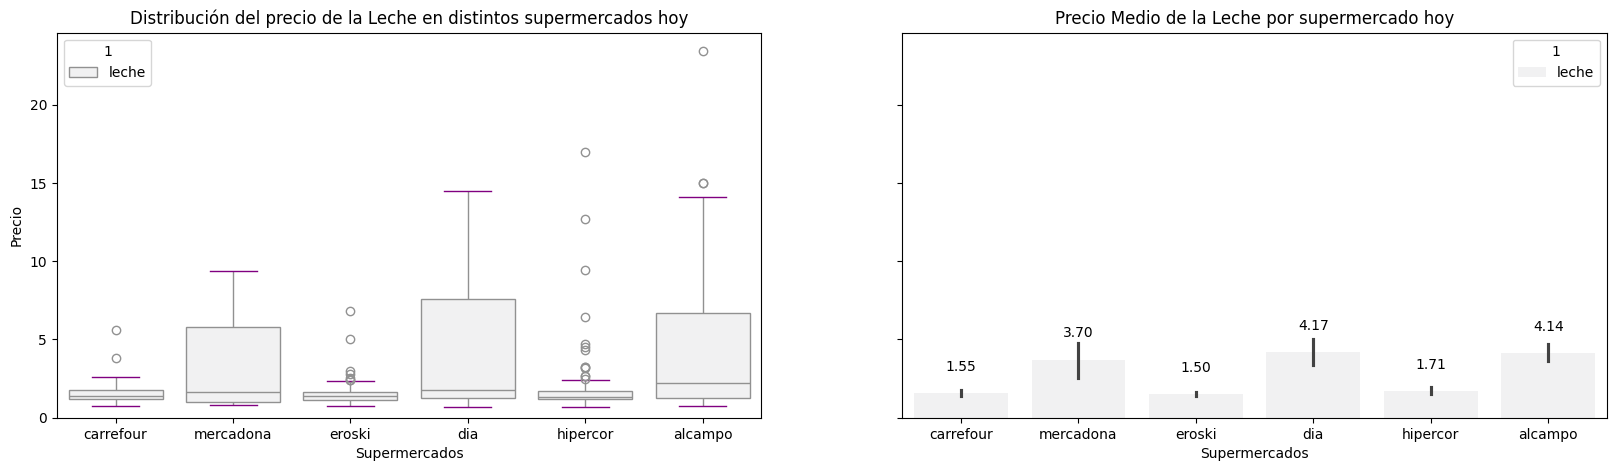

In [175]:
datos_grafico_comparacion_max_min(0,2,1,df_comparacion_max_min_leche,"light:blue","Leche",14)

In [176]:
cursor=conexion.cursor()
query_comparacion_max_min_oliva="""
SELECT m.super ,p2.producto, p.precio
FROM mercados m
INNER JOIN principal p ON m.id_super = p.id_super
INNER JOIN productos p2 ON p.id_producto = p2.id_producto 
WHERE (fecha = current_date AND p2.producto = 'aceite-de-oliva') ;
"""
cursor.execute(query_comparacion_max_min_oliva)
df_comparacion_max_min_oliva= pd.DataFrame(cursor.fetchall())

In [177]:
df_comparacion_max_min_oliva.head()

,0,1,2
0,carrefour,aceite-de-oliva,9.48
1,carrefour,aceite-de-oliva,9.07
2,carrefour,aceite-de-oliva,51.20
3,carrefour,aceite-de-oliva,10.69
4,carrefour,aceite-de-oliva,11.21


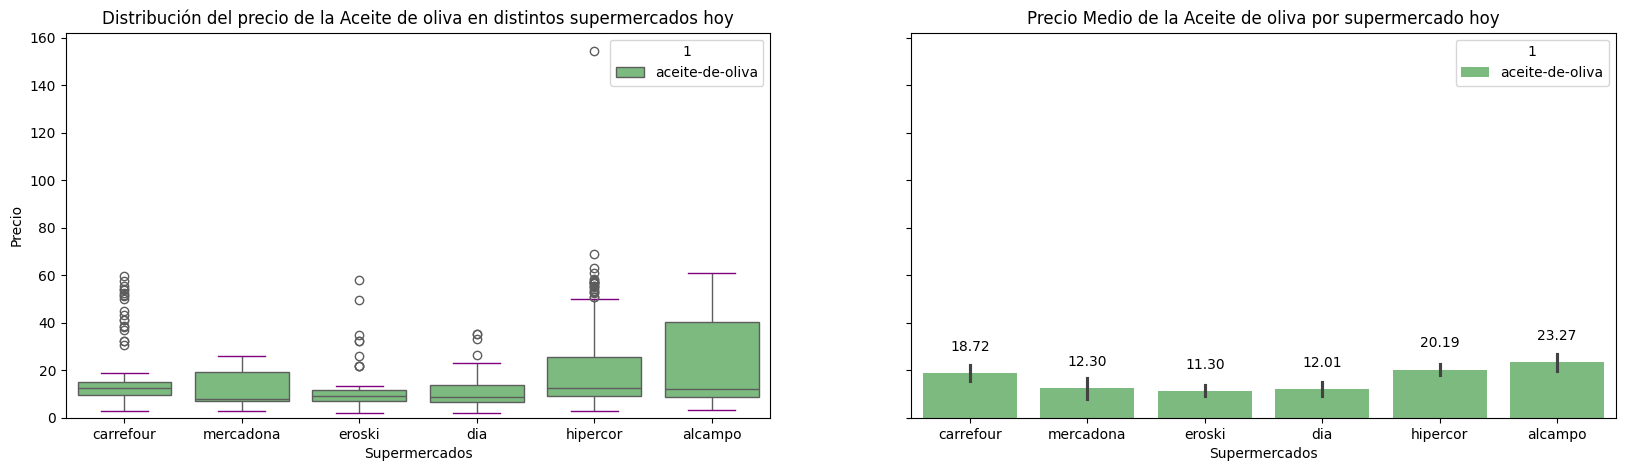

In [183]:
datos_grafico_comparacion_max_min(0,2,1,df_comparacion_max_min_oliva,"Greens","Aceite de oliva",14)

In [184]:
cursor=conexion.cursor()
query_comparacion_max_min_girasol="""
SELECT m.super ,p2.producto, p.precio
FROM mercados m
INNER JOIN principal p ON m.id_super = p.id_super
INNER JOIN productos p2 ON p.id_producto = p2.id_producto 
WHERE (fecha = current_date AND p2.producto = 'aceite-de-girasol') ;
"""
cursor.execute(query_comparacion_max_min_girasol)
df_comparacion_max_min_girasol= pd.DataFrame(cursor.fetchall())

In [185]:
df_comparacion_max_min_girasol.head()

,0,1,2
0,carrefour,aceite-de-girasol,21.90
1,carrefour,aceite-de-girasol,1.48
2,carrefour,aceite-de-girasol,10.55
3,carrefour,aceite-de-girasol,2.35
4,carrefour,aceite-de-girasol,12.65


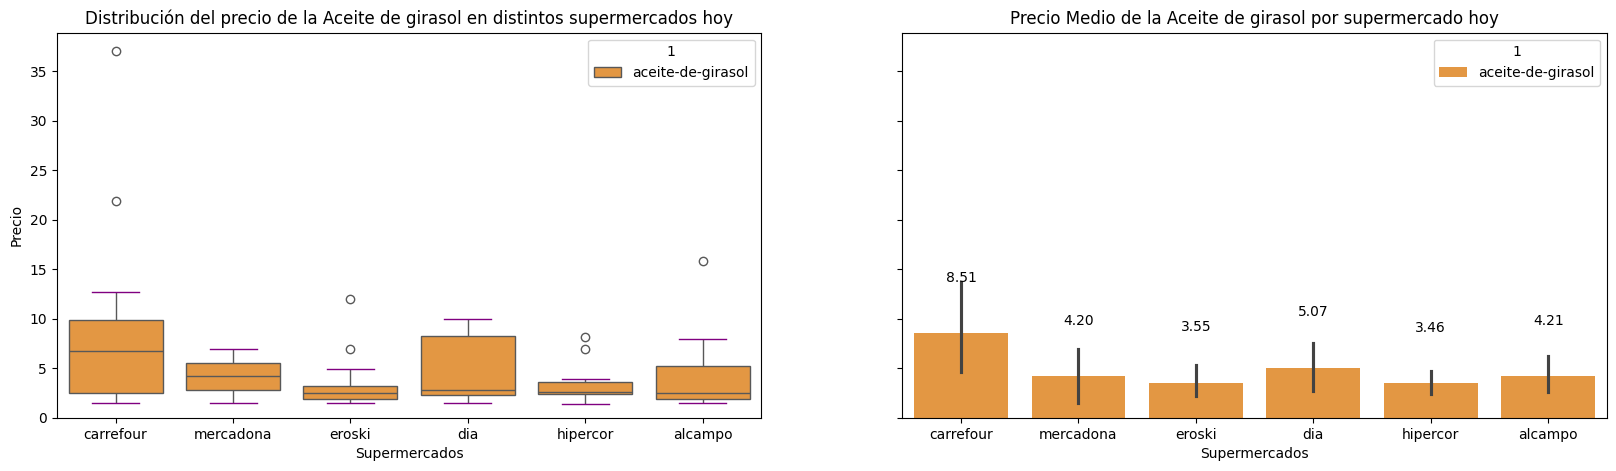

In [189]:
datos_grafico_comparacion_max_min(0,2,1,df_comparacion_max_min_girasol,"YlOrBr","Aceite de girasol",35)